In [2]:
import pandas as pd
from collections import Counter
import numpy as np
from pycaret.classification import ClassificationExperiment


- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [3]:
train_data = pd.read_feather('../data/train_data.ftr')

In [4]:
train_data.shape

(5531451, 191)

In [5]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [6]:
count_of_feature_type = Counter([
    x.split('_')[0] for x in train_data.columns
    if x not in ['customer_ID', 'target']
])
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=['count']).T
count_of_feature_type

,count
S,22
P,3
D,96
B,40
R,28


0    0.750903
1    0.249097
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

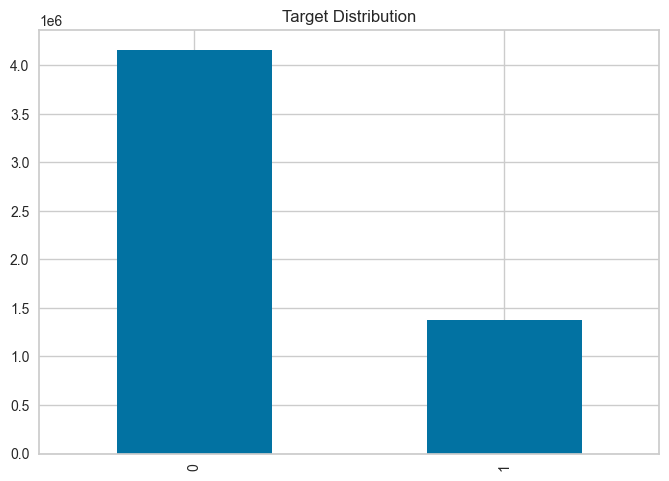

In [7]:
# calculate the percentage of training data that is 1 and 0
print(train_data['target'].value_counts(normalize=True))
train_data['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution')


In [8]:
train_data = train_data.sort_values(by=['customer_ID', 'S_2'])

In [9]:
# Extract the date information from the date column
train_data['Month'] = [i.month for i in train_data['S_2']]
train_data['Day'] = [i.day for i in train_data['S_2']]
train_data['Year'] = [i.year for i in train_data['S_2']]

In [10]:
# pick random 5000 customer_ID from train_data
np.random.seed(42)
customer_ID_rand = np.random.choice(train_data['customer_ID'], 20000, replace=False)

In [11]:
train_rndm_sample = train_data[train_data['customer_ID'].isin(customer_ID_rand)]


In [12]:
test_rndm_sample = train_data[~train_data['customer_ID'].isin(customer_ID_rand)].sample(80000).sort_values(by=['customer_ID', 'S_2'])

0    0.761049
1    0.238951
Name: target, dtype: float64


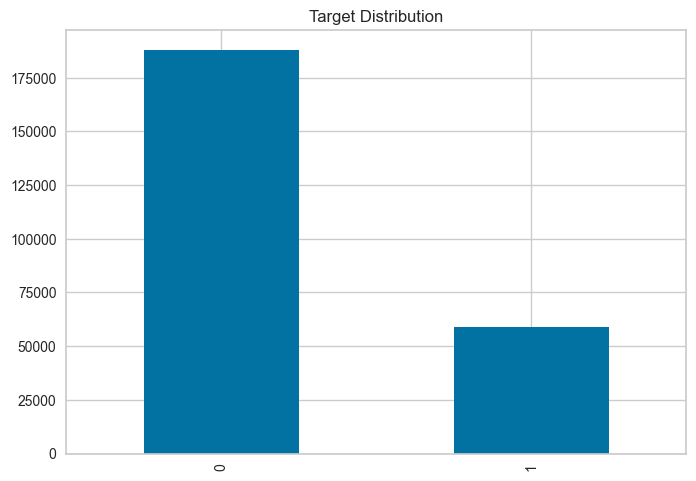

In [13]:
# calculate the percentage of training data sample that is 1 and 0
print(train_rndm_sample['target'].value_counts(normalize=True))
train_rndm_sample['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution');

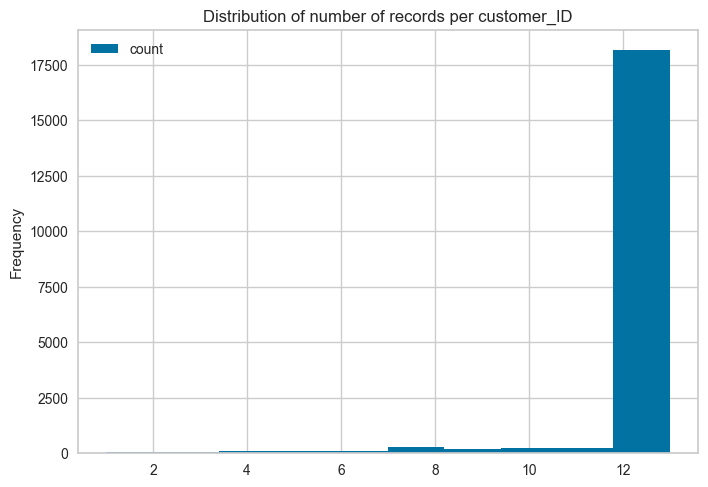

In [14]:
# calculate the number of records per customer_ID
records_per_cust = train_rndm_sample.groupby(
    'customer_ID').size().reset_index().rename(columns={
        0: 'count'
    }).sort_values(by='count', ascending=False)

# plot the distribution of number of records per customer_ID
records_per_cust.plot(
    kind='hist', title='Distribution of number of records per customer_ID');


In [15]:
s = ClassificationExperiment()
s.setup(data=train_rndm_sample, target='target', normalize=True, session_id=123, fold_strategy='timeseries', fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(246783, 194)"
4,Transformed data shape,"(336975, 227)"
5,Transformed train set shape,"(262940, 227)"
6,Transformed test set shape,"(74035, 227)"
7,Ordinal features,4
8,Numeric features,180
9,Date features,1


In [16]:
s.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [17]:
best = s.compare_models(include=['knn', 'xgboost', 'catboost', 'lightgbm', 'dummy'])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,07:50:15
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [18]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

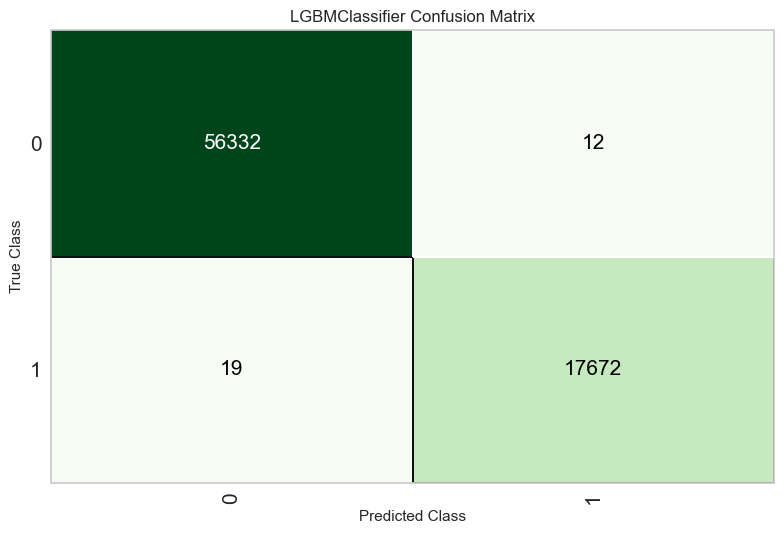

In [19]:
s.plot_model(best, plot = 'confusion_matrix')

In [20]:
pd.DataFrame(s.pull()).sort_values('F1', ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9751,0.9926,0.9511,0.9461,0.9485,0.9321,0.9321,3.907
catboost,CatBoost Classifier,0.9748,0.9927,0.9521,0.9444,0.9482,0.9315,0.9316,11.640
xgboost,Extreme Gradient Boosting,0.9744,0.9923,0.9480,0.9454,0.9467,0.9299,0.9299,13.054
knn,K Neighbors Classifier,0.9188,0.9708,0.9516,0.7711,0.8509,0.7963,0.8053,12.418
dummy,Dummy Classifier,0.7614,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.305


In [21]:
# Resutls on the test set based on the best model

predictions_test = s.predict_model(best, data=test_rndm_sample)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7888,0.8274,0.6000,0.5772,0.5883,0.4464,0.4465
